<a href="https://colab.research.google.com/github/CarloCV10/datasharing/blob/master/ARiMA_GDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Model AIC: 2782.15
Model BIC: 2813.43

ARIMA Coefficients p-values:
[2.73889581e-13 1.73275822e-04 3.57386904e-04 3.06188680e-07
 3.10191541e-36 9.97193220e-04 1.99030625e-04 5.85485322e-02
 1.50225150e-04 1.51765845e-17 0.00000000e+00]

Standard Errors (bse):
[1.03304078e-01 9.84835781e-02 1.04178404e-01 1.41666429e-01
 7.13739013e-02 1.51389921e-01 9.10768480e-02 1.18136551e-01
 1.92636300e-01 9.09421140e-02 2.30060266e-09]

 Training Set Performance:
MAPE (Train): 4.86%
RMSE% (Train): 4.42%

 Testing Set Performance:
MAPE (Test): 5.03%
RMSE% (Test): 7.47%


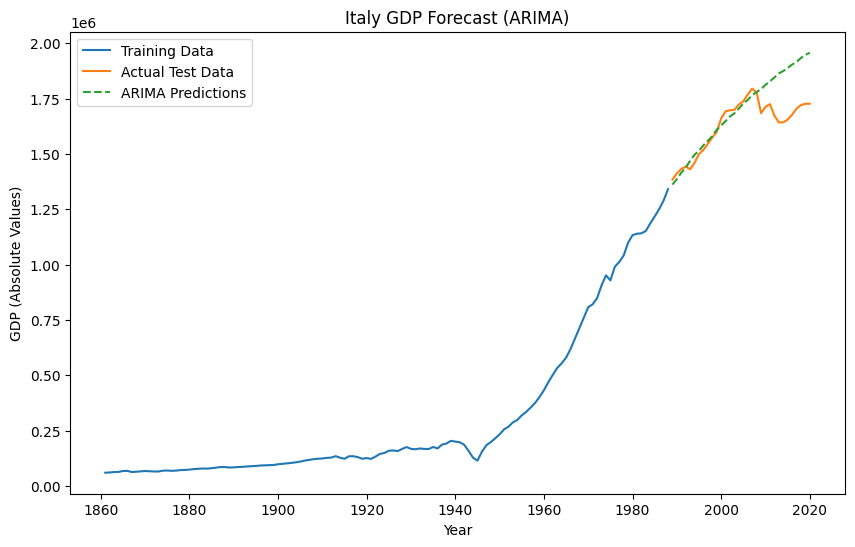

In [41]:
!pip install pmdarima statsmodels scikit-learn matplotlib pandas numpy

import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1. Read the CSV file
df = pd.read_csv('italy_gdp_data_arima.csv')

# 2. Sort by Year to ensure chronological order
df = df.sort_values(by='Year')

# 3. Extract year and GDP columns
years = df['Year'].values
gdp = df['Abs_GDP'].values  # or df['GDP'] if that is your column name

# 4. Train/test split (90% train, 10% test)
train_size = int(len(gdp) * 0.8)
train_data = gdp[:train_size]
test_data = gdp[train_size:]
train_years = years[:train_size]
test_years = years[train_size:]

# 5. Manually setting the best (p,d,q) instead of using AutoARIMA
best_p = 5
best_d = 1
best_q = 5

# 6. Fit the final ARIMA model
model = ARIMA(train_data, order=(best_p, best_d, best_q))
fitted_model = model.fit()

# 7. Print model statistics: AIC, BIC, p-values, standard errors
print(f"\nModel AIC: {fitted_model.aic:.2f}")
print(f"Model BIC: {fitted_model.bic:.2f}")

print("\nARIMA Coefficients p-values:")
print(fitted_model.pvalues)

print("\nStandard Errors (bse):")
print(fitted_model.bse)

# 8. Forecast for the training period (In-sample fit)
train_predictions = fitted_model.predict(start=0, end=train_size-1, typ='levels')


# 9. Simple forecasting
test_predictions = fitted_model.forecast(steps=len(test_data))  # Multi-step forecast in one go

# 10. Define MAPE function
def mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# 11. Compute MAPE & RMSE% for both training and test
train_mape = mape(train_data, train_predictions[:len(train_data)])
train_rmse = np.sqrt(mean_squared_error(train_data, train_predictions[:len(train_data)]))
train_rmse_perc = (train_rmse / np.mean(train_data)) * 100

test_mape = mape(test_data, test_predictions)
test_rmse = np.sqrt(mean_squared_error(test_data, test_predictions))
test_rmse_perc = (test_rmse / np.mean(test_data)) * 100

# 12. Print results
print(f"\n Training Set Performance:")
print(f"MAPE (Train): {train_mape:.2f}%")
print(f"RMSE% (Train): {train_rmse_perc:.2f}%")

print(f"\n Testing Set Performance:")
print(f"MAPE (Test): {test_mape:.2f}%")
print(f"RMSE% (Test): {test_rmse_perc:.2f}%")

# 13. Plot Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.plot(train_years, train_data, label='Training Data')
plt.plot(test_years, test_data, label='Actual Test Data')
plt.plot(test_years, test_predictions, label='ARIMA Predictions', linestyle='--')
plt.title('Italy GDP Forecast (ARIMA)')
plt.xlabel('Year')
plt.ylabel('GDP (Absolute Values)')
plt.legend()
plt.show()


In [16]:
from statsmodels.tsa.stattools import adfuller

# Compute first difference (equivalent to d=1)
first_diff = np.diff(train_data, n=1)

# Perform ADF test
adf_result = adfuller(first_diff)

# Print results
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# Interpretation
if adf_result[1] < 0.05:
    print("✅ The series is stationary at d=1 (p-value < 0.05)")
else:
    print("❌ The series is still non-stationary at d=1 (p-value >= 0.05)")


ADF Test Statistic: -1.191212332679684
p-value: 0.6773644745568292
❌ The series is still non-stationary at d=1 (p-value >= 0.05)


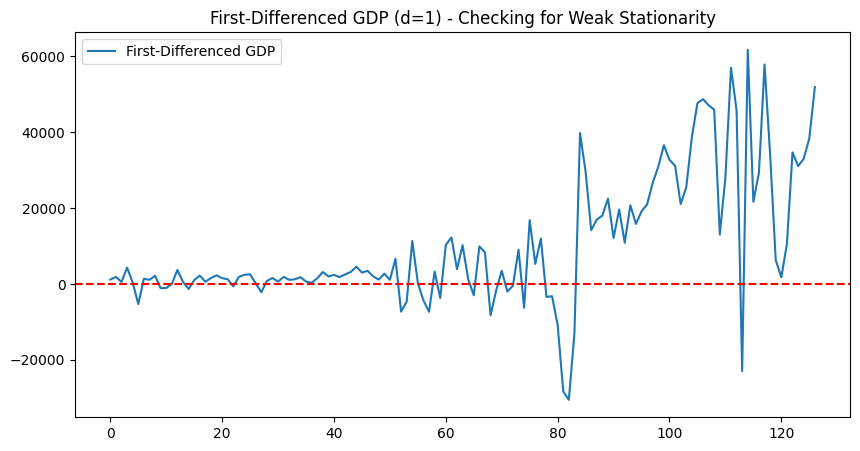

In [42]:
import matplotlib.pyplot as plt

# First Difference
first_diff = np.diff(train_data, n=1)

plt.figure(figsize=(10,5))
plt.plot(first_diff, label="First-Differenced GDP")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("First-Differenced GDP (d=1) - Checking for Weak Stationarity")
plt.legend()
plt.show()


Ok I think our arima part is completed. Help me write a paragraph that will fit into my 1 page report about comparing arima to fnn for GDP. Here we will describe the performance of the model, the tweaking that we have done for optimization, and the final conclusion/interpretation. As for tweaking, firslty, I turned the split back to 80/20, mostly because the 90/10 split was basically providing only the 2008-2020 period, a very fluctuatin and crisis like moment which is very hard to predict. Then, we have first used autoarima which was suggesting (based off bic and aic) values of 0,2 and 2. However these were performing very poorly due to the data overstretching in d=2. I tried changing the forecasting loop, changing the autoregression term, but the only thing which would take away the total linearity of the forecast was differencing to 1. i subsequently checked both visually and with ADF test whether d = 1 was enough. Unfortunately, it doesn't achieve strong stationarity. It is not entirely away from weak stationarity, but it is clear that between 1 and 2, the radeoffs are particularly limiting. Ultimately, my optimization lead me to three outcomes. Best I can offer is, MAPE (Test): 13.73% RMSE% (Test): 19.74% if I keep differencing at 2 (so stationarity is perfectly guaranteed) and pump up to 5 and 5 for p and q. P-values remain very good, there is a bit of an overfitting risk but the outcome coverges rapidly to a straight line so.
Or, I can be less rigorou sabout stationarity keep complexity relatively low (5 and 5, 4s running time), have MAPE (Test): 5.03% RMSE% (Test): 7.47%, keep optimal p-values without overfitting risk (residuals are normally distributed and white noise looking).

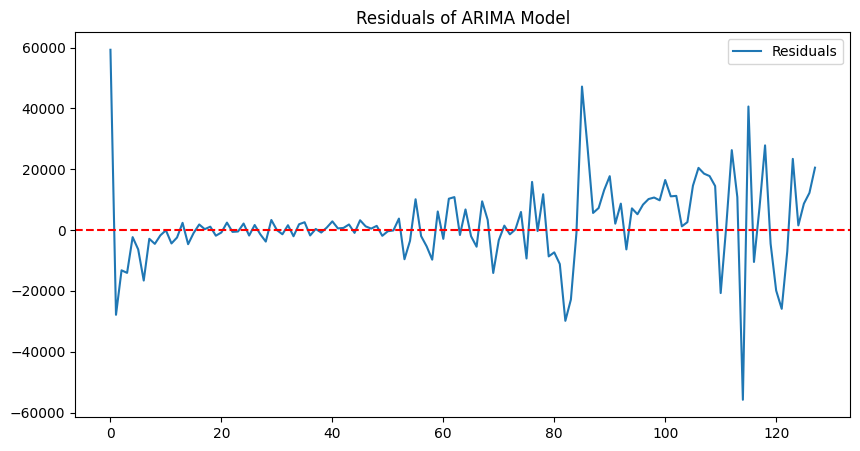

In [44]:
residuals = fitted_model.resid  # Get model residuals

plt.figure(figsize=(10,5))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals of ARIMA Model")
plt.legend()
plt.show()


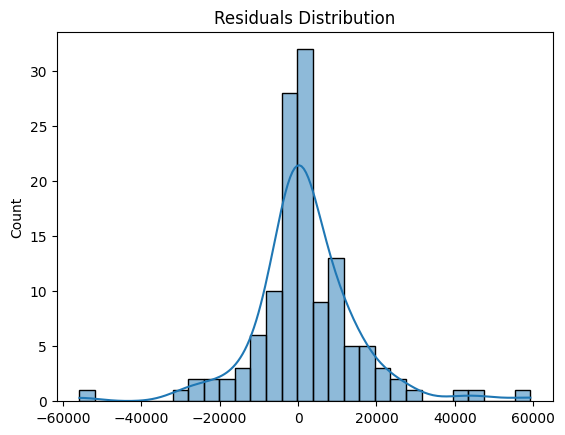

In [45]:
import seaborn as sns

sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

In [43]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_test)

     lb_stat  lb_pvalue
10  2.429214   0.991868


In [ ]:
!pip install pmdarima statsmodels scikit-learn matplotlib pandas numpy

import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1. Read the CSV file
df = pd.read_csv('italy_gdp_data_arima.csv')

# 2. Sort by Year to ensure chronological order
df = df.sort_values(by='Year')

# 3. Extract year and GDP columns
years = df['Year'].values
gdp = df['Abs_GDP'].values  # or df['GDP'] if that is your column name

# 4. Train/test split (90% train, 10% test)
train_size = int(len(gdp) * 0.9)
train_data = gdp[:train_size]
test_data = gdp[train_size:]
train_years = years[:train_size]
test_years = years[train_size:]

# 5. Use AutoARIMA to determine (p, d, q)
auto_arima_model = auto_arima(
    train_data,            # The training portion of GDP data
    start_p=0, start_q=0,  # Start with low order
    max_p=5, max_q=5,      # Reasonable bounds for AR and MA terms
    d=None,                # Let AutoARIMA find the order of differencing
    seasonal=False,        # Assuming no explicit seasonality in annual GDP
    trace=True,            # Print model selection steps
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Extract the best (p, d, q)
best_p, best_d, best_q = auto_arima_model.order
print(f"Best (p, d, q): ({best_p}, {best_d}, {best_q})")

# 6. Fit the final ARIMA model
model = ARIMA(train_data, order=(best_p, best_d, best_q))
fitted_model = model.fit()

# 7. Print model statistics: AIC, BIC, p-values, standard errors
print(f"\nModel AIC: {fitted_model.aic:.2f}")
print(f"Model BIC: {fitted_model.bic:.2f}")

print("\nARIMA Coefficients p-values:")
print(fitted_model.pvalues)

print("\nStandard Errors (bse):")
print(fitted_model.bse)

# 8. Forecast for the training period (In-sample fit)
train_predictions = fitted_model.predict(start=0, end=train_size-1, typ='levels')


# 9. Rolling Forecast for the test period (Out-of-sample)
test_predictions = []
history = list(train_data)  # Start with training data

for t in range(len(test_data)):
    model = ARIMA(history, order=(best_p, best_d, best_q))  #SEE hardcoding possibility
    fitted_model = model.fit()
    yhat = fitted_model.forecast(steps=1)[0]
    test_predictions.append(yhat)
    history.append(yhat)  # Append predicted value, NOT actual test data

# 10. Define MAPE function
def mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# 11. Compute MAPE & RMSE% for both training and test
train_mape = mape(train_data, train_predictions[:len(train_data)])
train_rmse = np.sqrt(mean_squared_error(train_data, train_predictions[:len(train_data)]))
train_rmse_perc = (train_rmse / np.mean(train_data)) * 100

test_mape = mape(test_data, test_predictions)
test_rmse = np.sqrt(mean_squared_error(test_data, test_predictions))
test_rmse_perc = (test_rmse / np.mean(test_data)) * 100

# 12. Print results
print(f"\n Training Set Performance:")
print(f"MAPE (Train): {train_mape:.2f}%")
print(f"RMSE% (Train): {train_rmse_perc:.2f}%")

print(f"\n Testing Set Performance:")
print(f"MAPE (Test): {test_mape:.2f}%")
print(f"RMSE% (Test): {test_rmse_perc:.2f}%")

# 13. Plot Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.plot(train_years, train_data, label='Training Data')
plt.plot(test_years, test_data, label='Actual Test Data')
plt.plot(test_years, test_predictions, label='ARIMA Predictions', linestyle='--')
plt.title('Italy GDP Forecast (ARIMA)')
plt.xlabel('Year')
plt.ylabel('GDP (Absolute Values)')
plt.legend()
plt.show()
